# Mock Data for Compressed Matrices



### taken from `https://github.com/bamler-lab/webgl-entropy-coding`

## File Format Specification

We store $K$ compressed matrices $W_0, \dots, W_{K-1}$, and a single uncompressed vector $v_0$.

- For $k \in \{0, \ldots, K-1\}$, the matrix $W_k$ has dimension $N_{k+1} \times N_k$.
- The vector $v_0$ has dimension $N_0$.

Thus, the statement $v_K := W_{K-1} W_{K-2} \ldots W_0 v_0$ denotes a valid sequence of matrix-vector multiplications with matching dimensions, resulting in a vector $v_K$ with dimension $N_K$.

### Overall Container Format

The overall file layout is structured as follows:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K   & S_\text{max} & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32 & u32          & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

Here,

- `u<X>` (e.g., $u8$, $u32$) denotes an unsigned $X$-bit integer value;
- `i<X>` (e.g., $i8$) denotes a signed $X$-bit integer value;
- all numbers are stored in little endian byte order;
- `{u, i}<X>[size]`, i.e., a type followed by braces (e.g., $i8[N_0]$) denotes a densely packed array of `size` elements of the same type;
- $S_\text{max}$ is the maximum size of the compressed representation (see below) of any of the involved matrices $W_0, \ldots, W_{K-1}$, including matrix headers (as described below), measured in units of 16 bit (2 byte).
- `pad` contains either 0, 1, 2, or 3 bytes whose values will be ignored by the decoder;
  its length $l_\text{pad} \in \{0,1,2,3\}$ is determined such that $N_0 + l_\text{pad}$ is an integer multiple of $4$, so that the subsequent fields can be 32-bit aligned;
- the compressed representation of the matrices $W_0, \ldots, W_{K-1}$ is detailed below.

### Matrix Container Format

In the above overall container format, each matrix $W_k$ for $k\in \{0,\ldots,K-1\}$ is stored in the following layout:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta & \texttt{cursors} & \texttt{payload\_size} & \hat{w}_\text{min} & |G| & \texttt{cdf} & \texttt{pad} & \texttt{ppf}& \texttt{payload} \\ \hline
      \text{type:} & u32   & u32     & f32    & u32[N_{k+1}]     & u32                    & i8                 & u8  & u8[|G| + 1]  &  u8[(|G|+1) \operatorname{mod} 2]     & u8[256] & u16[\texttt{payload\_size}] \\ \hline
  \end{array}
$

- **TODO:** maybe we should flush the coders after each matrix. The overhead is negligible (32 bit per matrix row, i.e., same as the overhead for the `cursors`)

Here,

- $\delta$ is the distance between neighboring grid points; i.e., if $\hat{W}_k \in \mathbb{Z}^{N_{k+1}\times N_k}$ is the integer representation of the decoded quantized matrix, then the true quantized matrix is $W_k = \delta \hat{W}_k$, and thus, for a vector-matrix multiplication $v_{k+1} := W_k v_k$, we have $v_{k+1} = \delta \hat{v}_{k+1}$ where $\hat{v}_{k+1} := \hat{W}_k v_k$.
- `cursors` is an array of the size of the output dimension $N_{k+1}$ which, for each matrix row, contains an offset into `payload` where additional compressed data for this matrix row (if needed) starts; offsets are measured in units of 16 bit (2 byte), and relative to the start of the `payload` field (thus, `cursors[0]` is always `0`);
- `payload_size` is the length of the `payload` field, measured in units of 16 bit (2 byte);
  since the `payload_size` field directly follows the `cursors` field, `payload_size` can be interpreted as an $(N_{k+1}+1)$-th cursor pointing to where the compressed data for an additional matrix row would start if there was one more matrix row.
  - Due to payload padding (see below), `payload_size` is always even (so that all compressed matrix structs are 32-bit aligned).
- $\hat{w}_\text{min}$ is the smallest value present in the integer representation $\hat{W}_k$ of the quantized matrix.
- $|G|$ is the grid size; we assume a uniform grid, i.e., the integer representation $\hat{W}_k$ of the quantized matrix takes only values from the range $\{\hat{w}_\text{min}, {\hat{w}_\text{min} + 1}, \ldots, {\hat{w}_\text{min} + |G| - 1}\}$.
- `cdf` is the cumulative distribution function of the entropy model in 8-bit unsigned integer representation.
  Its interpretation is that it defines a probability mass function (PMF) via $\texttt{pmf}[r] := (\texttt{cdf}[r + 1] - \texttt{cdf}[r]) \operatorname{mod} 2^8 \;\forall r \in \{0, 1, \ldots, |G|-1\}$.
  Here, the "$\operatorname{mod} 2^8$" wraps only for the last entry, $\texttt{pmf}[|G|-1] = {(0 - \texttt{cdf}[r]) \operatorname{mod} 2^8} = 2^8 - \texttt{cdf}[|G|-1]$, which is enforced by the requirements $\texttt{cdf}[|G|] = 0$ and $\texttt{cdf}[|G|-1] > 0$, see below, and the fact that $\texttt{cdf}[|G|-1] < 2^8$ since $\texttt{cdf}[|G|-1]$ is an unsigned 8-bit integer.
  The `cdf` it satisfies the following properties:
  - The first $|G|$ entries of `cdf` make up a nonincreasing sequence: `cdf[0] <= cdf[1] <= ... <= cdf[|G| - 1]`.
  - `cdf[0] = cdf[|G|] = 0`.
  - `cdf[|G| - 1] > 0` (which implies that $|G| \geq 2$ since `cdf[0] = 0`);
    thus, the entropy model must not represent a delta distribution that puts all probability mass on a single grid point;
    this requirement enables a simplification in the implementation of the ANS algorithm while anyway only affecting the pathological edge case where all matrix elements of $\hat{W}_k$ are equal.
    This pathological edge case can still be treated efficiently, e.g., by setting $|G|=2$, setting $\hat{w}_\text{min}$ to the value taken by all matrix elements, and setting $\texttt{cdf} = [0, 255, 0]$.
    With these settings, the entropy model puts almost all probability mass on the entry taken by all matrix elements and only a tiny probability mass on an irrelevant dummy grid point, resulting in a cross entropy of $\log_2(\frac{256}{255}) \approx 0.0056$ bit per matrix element.
  - If `cdf[r] = cdf[r + 1]` for some $r \in \{0, \ldots, {|G|-2}\}$, then this means that the entropy model assigns zero probability mass to the value ${\hat{w}_\text{min} + r}$, and therefore $\hat{W}_k$ must not contain any matrix entry with value ${\hat{w}_\text{min} + r}$ because this value cannot be encoded with this entropy model.
- `pad` is either nothing or a single byte with arbitrary value that should be ignored by the decoder.
  This byte is inserted if the grid size $|G|$ is even to ensure that the `payload` can be properly 16-bit aligned.
- `payload` contains the compressed data, see below.

### Compressed Bit String Representation & Decoding

We define the format of the `payload` field in the above matrix container format by specifying the decoding process.
The encoding algorithm follows from this specification as encoding is inference over a decoder.

When decoding the $k$-th matrix with dimensions $N_{k+1}\times N_k$, the decoder operates on the $N_{k+1}$ matrices independently (and thus, possibly in parallel).
All decoders need read access to the shared `cdf` of the entropy model, the shared `payload` of the compressed matrix, and a coder-specific cursor $C_i$ that gets initialized at the beginning of each matrix-decoding process from `cursor[i]` declared in the matrix container format.
A practical implementation will likely also want to create a shared `ppf` lookup table that stores the inverse of `cdf` to speed up steps 2 and 3 below.

Decoding the $i$-th row of matrix $W_k$ works as follows:

- Initialize the row's cursor $C_i \gets \texttt{cursors}[i]$, where `cursors` is a field of the matrix container format specified above.
- Initialize an unsigned 32-bit coder state $S_i \gets (\texttt{payload}[C_i] \ll 16) \;|\; \texttt{payload}[C_i+1]$, where "$\ll$" denotes left bit-shift and "$|$" denotes bitwise or.
  Thus, the 32-bit coder state $S_i$ is initialized to the concatenation of the first two 16-bit words read off the `payload` starting from the row's initial cursor.
- Increment the curser accordingly: $C_i \gets C_i + 2$.
- For each column $j \in \{0,\ldots,N_k-1\}$ (in ascending order) do:
  1. Set `quantile` ← least significant 8 bits of the coder state $S_i$
  2. Set `r` to the uniquely defined number in $\{0,\ldots,|G|-1\}$ such that `cdf[r] <= quantile < cdf[r+1]`.
  3. Set the (integer representation of the) decoded matrix element to $(\hat{W}_k)_{ij} \gets r + \hat{w}_\text{min}$.
  4. Update the coder state $S_i \gets (S_i \gg 8) \times$ `((cdf[r+1] - cdf[r]) mod 256)` + `(quantile - cdf[r])`,
     where "$\gg$" denotes left bit shift (that is _unsigned_, i.e., it fills from the right with zero bits).
  5. If $S_i < 2^{16}$ (i.e., if the 16 most significant bits of the 32-bit number $S_i$ are all zero, or, equivalently, if $(S_i \gg 16) = 0$), then:
     - Update $S_i \gets (S_i \ll 16) \;|\; \texttt{payload}[C_i]$,
       where "$\ll$" denotes left bit shift, and "$|$" denotes bitwise `or` (this update can be understood as concatenating $\texttt{payload}[C_i]$ to $S_i$ since $\texttt{payload}[C_i]$ is a 16-bit unsigned integer).
     - Increment $C_i \gets C_i + 1$.

### Encoding

A valid encoder is any program that generates a file in the format specified above such that decoding the file with the decoding algorithm specified above generates the desired (quantized) matrices $\hat{W}_0, \ldots, \hat{W}_{K-1}$.

In practice, encoding a quantized matrix $W_k$ of shape $N_{k+1} \times N_k$ can be performed as follows:

- Prepare an integer representation $\hat{W}_k \in \mathbb{Z}^{N_k \times N_{k+1}}$ of the quantized matrix and determine its minimum $\hat{w}_\text{min} := \min_{i,j} (\hat{W}_k)_{ij}$ and grid size $|G| := \max_{i,j} (\hat{W}_k)_{ij} - \hat{w}_\text{min} + 1 \ge 2$.
- Prepare a suitable `cdf` for $\hat{W}_k$.
- Initialize `reverse_payload` ← empty growable array of `u16`.
- For each row $i \in \{0,\ldots,N_{k+1}-1\}$ in _descending_ order, do (note: this could be parallelized without changing the result):
  - Initialize an unsigned 32-bit coder state $S \gets 2^{16}$.
  - For each column $j \in \{0,\ldots,N_k-1\}$ in _descending_ order, do:
    1. Set $r \gets (\hat{W}_k)_{ij} - \hat{w}_\text{min}$; (thus, $r \in \{0,\ldots, |G|-1\}$).
    2. Set `probability ← (cdf[r+1] - cdf[r]) mod 256`.
    3. If $(S \gg 24) \geq \texttt{probability}$ (i.e., if dividing $S$ by `probability` and then shifting it by 8 bit to the left would overflow its 32-bit size):
       - Push the 16 least significant bits of $S$ to the end of `reverse_payload`.
       - Update $S \gets (S \gg 16)$.
    4. Set $\texttt{quantile} \gets \texttt{cdf}[r] + (S \,\operatorname{mod}\, \texttt{probability})$;
       thus, $\texttt{quantile} \in \{0, \ldots, 255\}$.
    5. Update $S \gets (\lfloor S / \texttt{probability} \rfloor \ll 8) \;|\; \texttt{quantile}$,
       where "$\lfloor \,\cdot\,\rfloor$" denotes rounding down to an integer.
  - Push first the least significant 16 bit and then the most significant 16 bit of $S$ to the end of `reverse_payload`.
  - Set `back_cursor[i] ← length(reverse_payload)`, where length is measured in units of 16 bit.
- Obtain `payload` by reversing the order of elements in the array `reverse_payload`.
- For each $i \in \{0,\ldots,N_{k+1}-1\}$, set `cursor[i] ← length(payload) - back_cursor[i]`.
  Thus, we should have `cursor[0] = 0`.
- if `payload` has an odd length (i.e., contains an odd number of `u16`s), then append a single additional `u16` with arbitrary value (e.g., zero) to it to make it an even length.

In [1]:
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import struct
import sys

## Create Random Quantized Matrices

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


mins: [-123 -122 -127 -119 -120 -123 -127 -123 -123 -127 -127 -126 -113 -118
 -127 -119 -127 -127 -127 -119]
maxs: [127 127 113 127 127 127 125 127 127 127 122 127 127 127 120 127 123 124
 124 127]
(20, 4096, 4096)


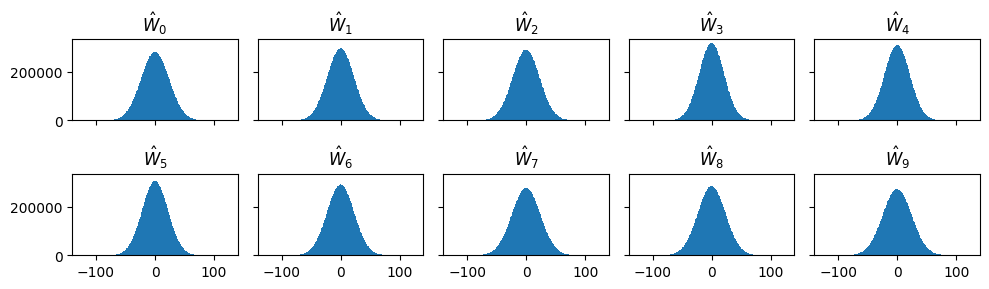

In [2]:
np.random.seed(20250310)
w = 4096
sigma = 1/np.sqrt(w)

n = 20

quantized_matrices = np.empty((n,w,w), dtype=np.int8)
w_deltas = np.zeros(n)
for i in tqdm(range(n)):
    matrix = np.random.randn(w, w)* sigma
    w_delta =  np.abs(matrix).max()/ 127 # quantize matrices to int8 grid
    w_deltas[i] = w_delta # store as weight delta
    quantized_matrices[i,...] = np.round( matrix/ w_delta ).astype(np.int8)

print(f'mins: {quantized_matrices.min(axis=(1, 2))}')
print(f'maxs: {quantized_matrices.max(axis=(1, 2))}')

fig, axs = plt.subplots(2, 5, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
bins = np.arange(-np.abs(quantized_matrices).max() - 0.5, np.abs(quantized_matrices).max() + 1.5)
for i, ax in enumerate(axs.flat):
    ax.hist(quantized_matrices[i ].ravel(), bins=bins)
    ax.set_title(r'$\hat{W}_{' + str(i) + r'}$')

vector = np.round(np.random.randn(w)).astype(np.int8)
print(quantized_matrices.shape)

## Calculate Result in python

In [3]:
deltas_a = np.zeros(n)
v_delta = 1
v_int8 = vector.copy()
for i,mat in enumerate(quantized_matrices):
    # .astype(np.int32) to not overflow while accumulating
    v_int32 = (mat.astype(float) @ v_int8.astype(float))
    
    # times w_deltas and v_delta to scale back to original values
    v_f32 = v_int32 * w_deltas[i] * v_delta

    # requantization to align again to  int8 
    v_delta = np.abs(v_f32).max() / 127 

    v_int8 = (v_f32 / v_delta)
    v_int8 = np.round(v_int8) # rounding for quantization

print(list(v_int8))

[16.0, 65.0, 23.0, -4.0, 25.0, 12.0, 2.0, -36.0, -0.0, 127.0, 91.0, 43.0, -49.0, 7.0, -27.0, -2.0, 10.0, 54.0, 3.0, -34.0, -38.0, -73.0, 8.0, -14.0, -16.0, 20.0, -28.0, -7.0, 2.0, -38.0, 4.0, -14.0, 4.0, 0.0, -13.0, 9.0, 7.0, -36.0, 61.0, -53.0, -20.0, 6.0, -46.0, -24.0, -4.0, 6.0, 8.0, -6.0, -55.0, 8.0, -30.0, 10.0, 33.0, -7.0, 31.0, 41.0, 23.0, -15.0, -23.0, -13.0, 55.0, -28.0, -21.0, -8.0, 44.0, -44.0, -15.0, 9.0, 3.0, 50.0, -11.0, 25.0, 8.0, 93.0, -7.0, -30.0, -30.0, -6.0, -47.0, 1.0, -13.0, -12.0, -4.0, -14.0, 22.0, -12.0, -23.0, 28.0, 11.0, -19.0, -66.0, -15.0, -8.0, 1.0, -37.0, 0.0, -53.0, 28.0, 52.0, -9.0, 37.0, -40.0, -5.0, -3.0, -41.0, 34.0, -45.0, 11.0, 38.0, 4.0, -1.0, -49.0, 79.0, 31.0, -84.0, -6.0, 26.0, -4.0, -43.0, -77.0, 53.0, 5.0, -25.0, 66.0, 6.0, -9.0, -16.0, 15.0, -53.0, 51.0, 29.0, 59.0, 42.0, -11.0, -16.0, 18.0, -12.0, 51.0, 17.0, -57.0, 25.0, -46.0, 68.0, -25.0, 14.0, -22.0, 8.0, -20.0, 21.0, -26.0, -27.0, 35.0, -29.0, 24.0, 42.0, -22.0, -60.0, -59.0, 0.0, 7.0, 

In [4]:
vec = vector
print(vector)
for i in range(len(quantized_matrices)):
    res = quantized_matrices[i] @ vec
    # print(quantized_matrices[i,0,:])
    vec = res
print(list(res))

[ 1  1  0 ... -1 -1 -1]
[17, 57, 22, 120, 31, -51, 73, 81, 96, -33, 82, -46, 0, 49, -91, 112, 76, 69, 31, 49, -14, -22, 40, 85, 75, -10, -80, -95, 11, -86, 68, -60, 62, 9, 25, -1, -22, 28, -115, -107, 86, -109, -25, -106, -6, -9, -111, 112, -84, 63, -43, 101, -55, -35, 28, -58, -11, 19, -104, -40, 60, -67, 3, 12, 82, -87, -80, 35, 69, -8, -8, -4, -109, 22, -115, -46, 105, -90, 89, 85, 35, 120, -64, -84, 118, -18, 37, -18, 15, 98, 112, -80, 79, -6, 61, -126, -35, -71, -125, -119, -115, 19, -121, 61, -38, 70, -47, -23, -36, -21, 16, 54, -60, 65, -32, 10, 34, -115, 2, 42, 91, 42, -103, -10, 88, 10, -103, -123, 70, 42, -31, -122, 39, -29, 88, 77, 38, 55, -46, -127, -74, 34, 37, 10, -87, -43, 103, -90, 69, -39, -89, 103, -92, -123, -37, 102, 97, 117, 61, 35, 105, -89, 35, 41, 44, -96, 83, -85, -4, -9, 101, -52, -124, 50, 74, -82, -67, -118, -46, 8, 9, 70, -102, 58, 117, 83, -106, 48, -35, 66, 89, 103, -39, -40, 54, -27, -43, 25, 115, -65, 21, 26, 6, -3, 80, -110, -33, 74, -89, -111, -120, 1

In [5]:
mat0 = quantized_matrices[0]
mat1 = quantized_matrices[1]
vector = np.array(vector, dtype=float)
mat0 = np.array(mat0, dtype=float)
mat1 = np.array(mat1, dtype=float)
print(mat0@vector)
mat1@mat0@vector

[-410.  451. -298. ... -243. -185. -862.]


array([  850891.,  5175418.,  1794722., ...,   -51129.,  2140000.,
       -1217947.])

## Write `raw-matrices.bin` for baseline comparison
Uses the same overall container format but stores matrix elements in column major ordering

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K    & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32  & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

$
  \begin{array}{|r||c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta &    \texttt{payload} & \texttt{padding} \\ \hline
      \text{type:} & u32   & u32     & f32    &  i8[N_{k+1}N_k]  & i8[N_{k+1}N_k mod 2]  \\ \hline
  \end{array}
$ 

If the number of rows or columns is not divisible by 2 the last byte of `payload` is padded with zeros.

In [6]:
def serialize_file_header_raw(file, num_matrices): # omitting max word count
    print(f"Num_matrices: {num_matrices}")
    file.write(struct.pack('<L', num_matrices))

def serialize_vector_raw(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    print(vec[-10:])
    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

def serialize_raw_matrix(file, matrix):

    file.write(struct.pack(
        f'<LLf',
        *matrix.shape,1.))
    print(matrix.shape)

    if sys.byteorder == 'little': 
        matrix.flatten(order="F").astype(np.int8).tofile(file) # F for FORTRAN saves matrix in column major format
    else:
        matrix.flatten(order="F").astype(np.int8).byteswap().tofile(file)

    if matrix.size % 2 != 0: 
        file.write(b'\0') # padding for if matrix does not have an even amount of 


with open('raw-matrices.bin', 'wb') as file:
    serialize_file_header_raw(file, len(quantized_matrices))
    serialize_vector_raw(file, vector)
    for matrix in quantized_matrices:
        serialize_raw_matrix(file, matrix)

Num_matrices: 20
len_v: 4096
[ 0.  0. -2. -2. -1.  0.  0. -1. -1. -1.]
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


## Create Entropy Models

In [7]:
def create_entropy_model(data, precision):
    min_value = data.min().item()
    max_value = data.max().item()

    if min_value == max_value:
        # Special case: all values are the same. Due to a limitation of ANS coding, we have
        # to create a dummy extra grid point with the smallest possible nonzero probability.
        grid_size = 2
        cdf = np.array([0, (1 << precision) - 1, 1 << precision], dtype=np.uint16)
        entropy = 0
        # To avoid loss of precision, we use `log1p(x) := log(1 + x)`, and thus:
        # cross_entropy = - log2((2^p - 1) / 2^p) = - log2(1 - 1 / 2^p) = - log1p(-1 / 2^p) / log(2)
        cross_entropy = - np.log1p(-1 / (1 << precision)) / np.log(2)
    else:
        grid_size = max_value - min_value + 1
        values, counts = np.unique(data, return_counts=True)

        # Sort descendingly by `counts`.
        order = np.argsort(counts)[::-1]
        values = values[order]
        counts = counts[order]

        scale = (1 << precision) / data.size
        probs = np.maximum(1, np.round(counts * scale).astype(np.uint16))

        excess = sum(probs).item() - (1 << precision)
        if excess > 0:
            # Shave off some probability mass from the most probable entries
            assert excess <= len(counts)
            while excess > 0:
                num_reducible_entries = (probs > 1).sum()
                num_reduce = min(excess, num_reducible_entries)
                assert num_reduce > 0
                probs[:num_reduce] -= 1
                excess -= num_reduce
            probs[:excess] -= 1
        elif excess < 0:
            # Spread some probability mass to the least probable entries.
            assert -excess <=len(counts)
            probs[excess:] += 1

        assert probs.sum() == 1 << precision

        entropy = np.log2(data.size) - (counts @ np.log2(counts)) / data.size
        cross_entropy = precision - (counts @ np.log2(probs)) / data.size

        padded_pmf = np.zeros(grid_size + 1, dtype=np.uint16)
        for value, prob in zip(values, probs):
            padded_pmf[value - min_value + 1] = prob

        cdf = np.cumsum(padded_pmf, dtype=np.uint16)
        assert cdf[0] == 0
        assert cdf[-1] == 1 << precision

    return min_value, grid_size, cdf, entropy, cross_entropy

In [8]:
def create_ppf(cdf, p_precision= 8):
    # handcrafet for 8 bit precision (weights && probs)
    # TODO generalize to arbitrary weight and prob precisions

    ppf = np.zeros((1<<p_precision), dtype=np.uint8) # ppf is of size 2**p_prec
    # for each possible probability save its corresponding value of the cdf
    for p in range ((1<< p_precision)):
        for r in range(len(cdf)-1,0,-1):
            if (cdf[r-1] & 0xFF).astype(np.uint8) <=p:
                ppf[p]= r-1
                break
            


    # ppf[1<<p_precision] = len(cdf) -1
        

    assert ppf[-1] == len(cdf)-2 # for 8-bit integer weights
    assert ppf[0] == 0
    return ppf
            

248
256


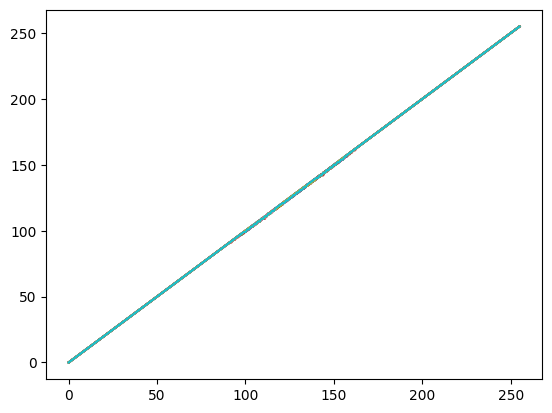

In [9]:
for i,m in enumerate(quantized_matrices):
    min_value, grid_size, cdf, entropy, cross_entropy = create_entropy_model(m, 8)
    ppf = create_ppf(cdf)


    plt.plot([cdf[w] for w in ppf], label=f"{i}")
    # if not np.all(np.array([ppf[p] for p in cdf if p < 256]) == np.arange(len(cdf)-1)):
        # print("ääää")
        # print(ppf)
        # print(cdf)
# plt.plot(np.arange(42))
print(len(cdf))
print(len(ppf))
# plt.legend()

## Entropy Coder

In [10]:
class AnsCoder:
    def __init__(self, precision, word_size, compressed=[]):
        self.precision = precision
        self.word_size = word_size
        self.word_mask = (1 << word_size) - 1
        self.quantile_mask = (1 << precision) - 1
        self.bulk = compressed.copy()
        self.head = 0
        while len(self.bulk) != 0 and (self.head >> word_size) == 0:
            self.head = (self.head << word_size) | self.bulk.pop()

    def push(self, symbol, cdf):
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        if (self.head >> (2 * self.word_size - self.precision)) >= prob:
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size

        # print(f'pushing {symbol} with prob {prob} and cdf {cdf[symbol]} onto {self.head}')
        z = self.head % prob + cdf[symbol].item()
        self.head = ((self.head // prob) << self.precision) | z

    def pop(self, cdf):
        z = self.head & self.quantile_mask
        self.head >>= self.precision
        symbol = cdf.searchsorted(z, side='right').item() - 1
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        self.head = self.head * prob + (z - cdf[symbol].item())
        if (self.head >> self.word_size) == 0 and len(self.bulk) != 0:
            self.head = (self.head << self.word_size) | self.bulk.pop()
        return symbol

    def get_compressed(self):
        compressed = self.bulk.copy()
        head = self.head
        while head != 0:
            compressed.append(head & self.word_mask)
            head >>= self.word_size
        return compressed
    
    def interrupt(self):
        while self.head != 0:
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size
        self.head = 1 << self.word_size
        return len(self.bulk)

## Compress the Matrices

In [11]:
class CompressedMatrix:
    def __init__(self, rows, cols, grid_spacing, cursors, min_value, cdf,ppf, payload):
        self.rows = rows
        self.cols = cols
        self.grid_spacing = grid_spacing
        self.cursors = cursors
        self.min_value = min_value
        self.cdf = (cdf & 0xFF).astype(np.uint8) # only take lowest 8 bit
        self.ppf= (ppf & 0xFF).astype(np.uint8)

        self.payload = payload # unpadded; will be padded to an even length upon serialization.
    
    def compressed_word_count(self):
        evend_payload_size = len(self.payload) + len(self.payload) % 2
        return (4 + self.rows) * 2 + (3 + len(self.cdf)) // 2 + evend_payload_size

    def serialize(self, file):
        payload_size = len(self.payload) 
        file.write(struct.pack(
            f'<LLf{self.rows}LLbB{len(self.cdf)}B',
            self.rows,
            self.cols,
            self.grid_spacing,
            *self.cursors,
            payload_size,
            self.min_value,
            len(self.cdf) - 1,
            *(self.cdf),
        ))

        if len(self.cdf) % 2 == 1:
            file.write(b'\0')
        
        # writing ppf 
        file.write(struct.pack(
            f'<256B',*(self.ppf)
        ))

        if sys.byteorder == 'little':
            self.payload.tofile(file)
        else:
            self.payload.byteswap().tofile(file)

        if len(self.payload) % 2 == 1:
            file.write(b'\0\0')
    
    @staticmethod
    def deserialize(file):
        """ Reads binary data from a file and reconstructs a CompressedMatrix object """
        # read number of rows and columns and grid_spacing
        rows, cols, grid_spacing = struct.unpack("<LLf", file.read(12))

        # get cursors using number of rows
        cursors = np.fromfile(file, dtype=np.uint32, count=rows) #check
        
        # get payload size
        payload_size, min_value, G = struct.unpack("<LbB",file.read(6))
        
        # Read the CDF values
        cdf_len = G + 1
        cdf_data = np.fromfile(file, dtype=np.uint8, count=cdf_len)
        if cdf_len % 2 == 1:
            file.seek(1,1)

        ppf = np.fromfile(file, dtype=np.uint8, count=256)
        # read payload
        payload = np.fromfile(file, dtype=np.uint16, count=payload_size)

        # skip 2 bytes if payload is an uneven number of 
        if payload_size % 2 ==1:
            file.seek(2,1)           

        # If system is big-endian, swap bytes
        if sys.byteorder != 'little':
            payload = payload.byteswap()

        return CompressedMatrix(rows, cols, grid_spacing, cursors, min_value, cdf_data,ppf, payload)

In [12]:
def encode_matrix(matrix, precision = 8):
    min_value, _grid_size, cdf, _entropy, _cross_entropy = create_entropy_model(matrix, precision)
    ppf = create_ppf(cdf)
    # print(len(cdf))
    coder = AnsCoder(precision, 16, [0, 1])
    back_cursors = np.empty(matrix.shape[0], dtype=np.uint32)

    for row in range(matrix.shape[0] - 1, -1, -1): # iterates in reverse order 
        for entry in matrix[row, ::-1]: # iterates in reverse order due to stack semantics of ANS
            coder.push(entry.item() - min_value, cdf)
        back_cursors[row] = coder.interrupt()
    
    payload = np.array(coder.bulk[::-1], dtype=np.uint16)
    cursors = len(payload) - back_cursors
    return CompressedMatrix(matrix.shape[0], matrix.shape[1], 1.0, cursors, min_value, cdf,ppf, payload) # 1 here is for debugging purposes?

encoded_matrices = [encode_matrix(matrix) for matrix in tqdm(quantized_matrices)]

100%|██████████| 20/20 [17:13<00:00, 51.66s/it]


## Serialize to a file

In [13]:
def serialize_file_header(file, num_matrices, max_word_count):
    print(f"Num_matrices: {num_matrices}, Max_word_count: {max_word_count}")
    file.write(struct.pack('<LL', num_matrices, max_word_count))

def serialize_vector(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

In [14]:
max_word_count = max(m.compressed_word_count() for m in encoded_matrices)

with open('compressed_matrices.bin', 'wb') as file:
    serialize_file_header(file, len(quantized_matrices), max_word_count)
    serialize_vector(file, vector)
    for matrix in encoded_matrices:
        matrix.serialize(file)

!ls -l compressed_matrices.bin
!ls -lh compressed_matrices.bin

Num_matrices: 20, Max_word_count: 8299311
len_v: 4096
-rw-r--r-- 1 wildug wildug 322328918 23. Mai 08:33 compressed_matrices.bin
-rw-r--r-- 1 wildug wildug 308M 23. Mai 08:33 compressed_matrices.bin


## Read from a file:

In [15]:
def decode_mat(quant_mat, precision = 8, k = 0):
    # TODO remove k
    for r in range(1,quant_mat.rows):
        cursor = quant_mat.cursors[r]
        cursorp1 = quant_mat.cursors[r+1]
        print(cursor, cursorp1, len(quant_mat.payload))
        coder = AnsCoder(precision, 16, list(quant_mat.payload[cursor:cursorp1])[::-1]) # the ::-1 is VERY important
        for c in range(30):
            print("Head: ",coder.head)
            print("Bulk: ",coder.bulk[-5:][::-1])
            w = coder.pop(quant_mat.cdf)+quant_mat.min_value
            print("Dec:",w, " col:", c)
            assert w == quantized_matrices[k,r,c]
        print("blob")

        # print()
        break

In [16]:
with open('compressed_matrices.bin', 'rb') as file:
    # read first 12 bytes for num_matrices, max_word_count and length of vector

    num_matrices, max_word_count, len_v  = struct.unpack("<LLL", file.read(12)) # check
    print("num_matrices: ",num_matrices)
    print("max_word_count: ",max_word_count)
    print("len_v: ",len_v)
    v = np.fromfile(file, dtype=np.int8, count=len_v) # check
    print("v[1]: ", v[1])

    pad_size = (3 - (len_v + 3) % 4)
    pad = struct.unpack(f"{pad_size}b",file.read(pad_size)) # check

    for k in range(num_matrices):
        quant_mat = CompressedMatrix.deserialize(file)
        print(len(quant_mat.cdf))
        for i,p in enumerate(list(quant_mat.cdf)):
            print(f"cdf[{i}]={p}")
        decode_mat(quant_mat,k = k)
        for attr1, attr2 in zip(vars(quant_mat), vars(encoded_matrices[k])):
            if attr1 != attr2:
                print(f"Mismatch: {attr1} != {attr2}")
            assert attr1 == attr2
        
        


num_matrices:  20
max_word_count:  8299311
len_v:  4096
v[1]:  1
252
cdf[0]=0
cdf[1]=1
cdf[2]=1
cdf[3]=2
cdf[4]=2
cdf[5]=3
cdf[6]=3
cdf[7]=4
cdf[8]=5
cdf[9]=6
cdf[10]=7
cdf[11]=8
cdf[12]=9
cdf[13]=10
cdf[14]=11
cdf[15]=12
cdf[16]=13
cdf[17]=14
cdf[18]=15
cdf[19]=16
cdf[20]=17
cdf[21]=18
cdf[22]=19
cdf[23]=20
cdf[24]=21
cdf[25]=22
cdf[26]=23
cdf[27]=24
cdf[28]=25
cdf[29]=26
cdf[30]=27
cdf[31]=28
cdf[32]=29
cdf[33]=30
cdf[34]=31
cdf[35]=32
cdf[36]=33
cdf[37]=34
cdf[38]=35
cdf[39]=36
cdf[40]=37
cdf[41]=38
cdf[42]=39
cdf[43]=40
cdf[44]=41
cdf[45]=42
cdf[46]=43
cdf[47]=44
cdf[48]=45
cdf[49]=46
cdf[50]=47
cdf[51]=48
cdf[52]=49
cdf[53]=50
cdf[54]=51
cdf[55]=52
cdf[56]=53
cdf[57]=54
cdf[58]=55
cdf[59]=56
cdf[60]=57
cdf[61]=58
cdf[62]=59
cdf[63]=60
cdf[64]=61
cdf[65]=62
cdf[66]=63
cdf[67]=64
cdf[68]=65
cdf[69]=66
cdf[70]=67
cdf[71]=68
cdf[72]=69
cdf[73]=70
cdf[74]=71
cdf[75]=72
cdf[76]=73
cdf[77]=74
cdf[78]=75
cdf[79]=76
cdf[80]=77
cdf[81]=78
cdf[82]=79
cdf[83]=80
cdf[84]=81
cdf[85]=82
cdf[86]=

In [17]:
quantized_matrices[0,0,:10]

vals = [-19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
cdf = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 27, 38, 52, 70, 92, 116, 140, 164, 185, 203, 218, 229, 236, 241, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0]
len(vals), len(cdf)

(39, 39)

## Debugging

In [18]:
# Checksum adapted from rust's FxHash, but restricted to 26 bit hashes so that the
# multiplication doesn't exceed the range of exactly representable integers in JavaScript.
def get_checksum(data):
    checksum = 0
    for value in data.ravel():
        # Convert `value` into a unique positive value to avoid architecture- and
        # precision-dependent behavior in the bit manipulations below.
        value = value.item()
        if value < 0:
            # Negative `value`s are mapped to odd positive numbers ...
            value = -2 * value + 1
        else:
            # ... and positive `value`s are mapped to even positive numbers.
            value = 2 * value

        checksum = ((checksum & 0x001f_ffff) << 5) | (checksum >> 21) # rotate
        checksum = (checksum ^ value) * 0x0322_0a95
        checksum = checksum & 0x03ff_ffff # truncate to 26 bit
    return checksum

In [19]:
print(f'checksum of vector: {get_checksum(vector)}')

for i, quantized_matrix in enumerate(quantized_matrices):
    print(f'checksum of matrix {i}: {get_checksum(quantized_matrix)}')

TypeError: unsupported operand type(s) for ^: 'int' and 'float'

In [ ]:
baseline_out = [18, 63, 20, -5, 26, 15, 3, -34, -4, 127, 93, 43, -47, 5, -25, -2, 11, 53, 4, -32, -37, -70, 9, -17, -14, 19, -29, -5, 0, -38, 5, -14, 3, -1, -14, 7, 6, -33, 64, -51, -18, 6, -48, -25, -2, 3, 7, -4, -55, 6, -30, 11, 30, -9, 29, 39, 25, -14, -24, -14, 55, -27, -21, -9, 41, -45, -16, 10, -2, 49, -13, 24, 9, 94, -6, -29, -28, -2, -44, 0, -11, -13, -2, -15, 21, -12, -21, 28, 10, -22, -67, -14, -9, 2, -34, 1, -54, 26, 53, -10, 40, -40, -5, -5, -40, 34, -44, 10, 37, 7, -4, -48, 80, 29, -85, -10, 27, -5, -43, -75, 56, 9, -27, 65, 9, -11, -15, 14, -54, 51, 29, 60, 42, -7, -16, 15, -15, 51, 17, -58, 26, -47, 65, -22, 12, -21, 7, -22, 22, -29, -29, 37, -29, 24, 42, -20, -59, -61, -2, 9, -14, 33, -46, -7, -22, -60, -21, -1, 18, -45, -36, 4, -48, -24, -65, -44, -5, -29, -26, -14, 39, 51, 11, -10, 20, -19, 28, -10, 15, -21, 46, -11, 22, -3, -27, -36, -22, 22, -23, -36, 36, -16, -24, -3, -25, 31, -30, -18, -4, 3, -25, -23, 13, -42, 26, -71, -13, 27, 19, -7, 63, -1, 61, -9, 36, -26, -50, -62, 12, -31, 20, 48, -40, -28, 63, -2, -27, 79, 2, -27, -9, 1, 10, 23, 18, 10, -20, -84, 31, -18, 21, 3, -76, -66, 46, -45, 21, -13, -34, 50, 21, 28, 2, -6, -6, -12, 2, -46, -56, 33, 43, 28, -6, 20, 61, 36, -43, -20, -9, -35, -4, 11, 39, -57, -0, -43, 38, 20, -38, -22, 21, 26, 5, 4, -2, 39, 22, -20, 3, -8, 10, 65, -14, -44, -51, 4, 29, 44, -13, 4, -36, 41, -33, -18, 29, 6, -57, 50, -28, 4, 13, -60, -26, -67, 3, 76, -30, -36, 39, -22, 106, -60, -32, 51, 25, -15, -14, -37, -4, 11, 19, 2, -6, -30, 52, -36, 67, -2, 21, 58, -13, 20, 13, -6, 40, -49, 66, 12, 35, -10, 52, -20, 5, 35, -80, -11, -26, -31, -14, 28, -17, -24, -16, 75, -7, 41, -54, 15, 19, 62, 19, -31, -15, 23, 5, 25, -9, -5, 14, 46, 36, -20, -28, 27, 29, -19, 7, 7, 2, 89, -51, -14, -74, -5, 15, 11, 49, -24, -33, -9, 11, 22, -25, 26, -42, 12, 30, 23, 0, 8, -4, 38, -8, -42, 27, 50, 2, -27, 20, -6, 6, -24, 44, 3, 13, -42, 16, -9, -106, 22, -42, -9, -7, 28, -25, -48, 18, -46, 21, 10, 44, 26, -24, -37, 19, 9, -26, -34, 28, 4, 19, 47, -9, 21, -38, -5, -4, 7, 35, 29, -29, -57, -16, 45, 45, -43, -57, -56, 41, 76, -16, -8, -67, -1, 29, -19, -51, 18, 44, 65, -34, -43, 82, -33, 31, 20, -31, -3, 24, -24, 30, -7, -18, -4, -11, -63, 39, 52, 1, 50, 6, 45, 17, 7, -33, -3, -28, 12, -7, 51, -3, -4, 5, -45, 25, -27, 10, 55, -32, 24, -47, -21, -21, -82, 12, 11, -3, -77, -24, 36, -1, 24, -3, 7, -36, -28, 12, -10, -8, -1, -14, -34, -29, 2, -21, -44, -38, 2, 35, -27, 38, 64, -27, -41, 24, -23, -25, -17, 55, 33, 25, 22, -86, -30, 49, 9, -50, 75, 1, -29, 3, -5, -19, 41, -35, 37, 62, -12, 19, 38, -20, 33, 17, -21, 14, 8, -8, 29, 4, -36, -2, -23, -20, -8, -7, -20, 7, 38, 27, -42, -23, -23, -5, -39, -20, 47, -87, -12, -25, -6, 46, -25, -48, 26, -35, 60, 31, 16, 30, 3, 17, 17, -23, -37, -1, 52, -19, -1, 2, -43, -72, 58, -31, 52, 21, -15, -6, -42, 71, 25, -37, -70, 14, 27, -7, 2, 3, 16, -40, 3, -15, -53, -39, -9, 5, 35, -2, 63, 54, 12, -39, 9, 31, -12, -11, 81, -36, 22, 5, -38, 47, -43, -1, 23, 15, 21, 2, -18, 13, -23, 7, -14, -22, -24, -61, -16, 15, 74, -10, -41, -18, -2, 7, -66, 26, -25, 27, -71, -34, -41, -21, 28, -27, -25, -35, -60, -39, -63, -33, 45, 72, 16, 5, 1, 32, 8, 4, 1, 10, -29, -26, 15, 43, -14, 7, -16, -37, -42, 33, 3, 20, -23, -22, 33, 26, 58, 45, 45, -23, -32, 60, 3, 10, 2, 73, 9, -58, 27, -9, -1, 28, 15, 61, -6, -0, -5, -22, -20, -34, -23, -5, -2, -40, 30, 59, 19, 39, 33, 11, -31, 18, 49, -55, 31, 25, -34, -8, 11, -5, -53, 11, 1, -19, -38, -38, -69, 59, -50, -52, 39, 4, 61, 29, 10, -13, -3, 7, 24, 10, -1, 24, -2, -33, 36, 48, -55, 8, -8, 12, 44, 13, -8, -55, 39, 14, -27, -46, 0, -34, 24, -38, 46, -14, 53, -57, -23, 26, -3, 30, 44, 2, 12, -41, 61, -9, 38, 3, 11, -72, 10, 1, 12, -13, 44, 61, -30, -24, -40, -15, -38, -22, 46, 5, 51, 18, 46, -2, 35, -4, 53, 76, -28, -27, 42, -43, 28, -13, -32, -84, 30, -12, 0, 7, -13, 35, -3, 31, 31, -35, 69, -5, -24, -37, -67, 47, 8, -8, -12, 18, 7, -1, 19, -41, -25, 10, -1, -24, 16, 47, 21, -66, 7, -10, -43, 19, -0, 7, -40, 18, 15, 65, -16, -27, -41, 1, -47, 41, -54, 1, -36, -44, -41, 5, -50, -1, -61, -24, -16, 18, 22, -31, -23, 5, -24, -24, -34, -19, -19, -45, -22, -62, 7, -0, -13, -49, -32, -71, -1, 46, -3, 64, -7, 1, 3, -16, 14, 16, 33, 23, 42, -37, 6, 15, 10, -43, 40, 28, -80, 20, -42, -7, -12, 7, 24, -47, -46, -20, 23, 71, 1, -13, 54, 22, -7, -22, 39, 25, 6, 29, -47, -4, -32, 20, -8, 34, 25, 27, -49, -4, -49, -87, -27, -49, -47, -23, -5, 35, -29, 22, 35, -16, 15, -46, 44, -17, 48, -7, -8, 5, 10, -3, -10, -0, 24, -26, 23, -32, -33, -15, -4, 58, 2, -4, 20, 9, 56, 0, -3, 19, -67, -3, 10, -56, -7, 38, 12, 36, 7, 32, 28, -43, 0, -30, 36, -36, 13, 26, -17, -38, 34, 5, -28, -23, 7, 21, 34, -63, 4, 24, 38, -2, -44, 31, -33, 31, 9, -38, 4, 48, -1, -53, 20, -10, -5, 36, 70, 57, 63, 3, 22, 3, -61, -10, 49, -24, -19, 14, -33, -13, -36, 32, -30, 35, 8, 5, -30, 19, -6, -13, 26, 42, -42, 40, -97, -22, -73, 45, -37, 46, 13, -24, -67, -7, 10, -3, 17, 28, -31, 27, -5, -24, -5, -16, 29, 17, -6, -35, -3, -59, -16, 29, -15, -29, 47, 28, -25, 17, -4, -52, -61, 38, -84, 7, -40, 76, 13, -18, 30, 23, 20, 40, -1, -2, -37, -5, -46, -12, 15, -78, 14, 20, -49, -12, 25, -90, -59, -104, -2, 30, -82, -3, -15, 12, 10, -8, -22, -11, -42, 34, -50, 22, -33, -35, -29, -22, -78, 17, -8, -7, 22, 20, 2, -2, -47, -15, -26, 69, 21, -9, 27, -12, -1, 13, -47, 5, 4, 22, 2, 56, 26, -49, -7, -82, 12, 7, 18, 32, 5, -33, -16, 35, 42, -19, -23, 2, 20, -12, -73, -14, 39, 7, -9, -28, 31, -5, 47, -6, -59, 31, 7, -31, 27, 23, 43, 46, -33, 2, 56, 53, 5, 28, 52, -49, 7, -14, -44, 63, 37, 23, 32, -30, -40, 23, -29, -9, -22, 3, -51, 13, -10, 11, -2, -69, -20, -34, 16, 11, -44, -15, -24, -53, 44, -7, -9, -6, 1, 17, 31, 32, 43, -29, 1, 4, -12, -15, -40, 51, 10, 5, 11, -30, -1, 39, 18, 35, -59, -35, 61, 4, -9, 10, -32, 11, 44, 0, 3, -47, -6, -30, -16, -18, 8, 17, 1, -38, -70, 20, 30, -39, 14, 7, -14, -2, 10, 18, 13, 23, -27, -49, -30, -31, 26, 14, 14, 2, -20, 10, -16, 14, -40, 7, -40, -17, -28, 16, -16, 40, 75, 13, -3, 42, 8, -55, 13, -74, 33, -35, 30, 33, -9, -24, -8, -43, 11, -23, -29, -24, -14, -2, -6, 41, 10, 22, 13, -7, -65, 13, 8, 1, -48, -17, 53, 24, 1, 24, -21, -21, -17, 37, 14, -22, -7, -30, 12, -19, -59, -34, 19, -32, -34, 7, -15, -48, -3, -16, 29, -46, -2, -23, 44, -11, 6, 18, 3, -57, 27, -0, -64, 21, -52, -16, 47, -6, -11, 63, -68, 76, -6, 66, -0, 18, -22, 10, 6, -58, 4, -76, -51, 36, 10, -4, 7, 8, 21, -57, 28, 2, 31, -19, -20, -9, -28, 35, 16, -26, -33, -60, -46, 30, -96, 28, -14, -14, -15, 104, 5, 1, -34, -20, 21, -11, 45, -87, 23, -3, 16, 24, 6, 18, -17, -7, 22, -15, -4, 66, -58, 13, 21, -18, -19, 43, -53, 52, -6, 64, 34, 13, 32, 20, -29, 3, -10, 47, -29, 7, 37, 29, -5, -15, 3, -11, -4, -14, 99, -24, -9, 54, -23, 30, 57, 0, -66, -17, -40, 9, 36, -2, 47, 47, 42, -48, 48, -28, -63, 25, 3, 48, 21, 9, 47, -4, 50, 48, -14, 21, -27, -17, -6, 17, -17, -10, 48, 34, 8, 10, -16, 13, -76, -39, -24, 7, -0, -6, 5, -35, 32, 32, 8, -47, -13, 74, 20, 63, -36, -49, 9, 28, -1, 75, 52, 21, -22, 29, -48, 47, -9, -30, 20, -24, 74, 9, -16, 10, -4, 22, 77, -3, 7, 29, -23, 32, -0, 24, -18, -2, -62, 25, -13, -87, 14, 38, -31, -14, 24, -15, 3, 34, -26, -17, -35, -2, 40, 52, -40, 4, 17, -29, 32, -17, -25, -29, -3, -9, -27, 14, 33, 30, -24, -3, 11, -2, -46, 4, 5, -2, -17, 8, 15, -76, 1, -26, -9, -56, -17, -36, 19, 4, 20, -25, 4, 0, 30, 23, -51, -28, 39, -7, -29, 30, -51, 24, 19, 11, -7, -20, -17, 60, 39, -3, -46, 4, -3, 0, -40, -37, -49, -1, 26, -14, -19, -52, 17, 92, 25, 15, -7, 41, 0, 7, 17, 93, 31, 45, -81, 42, -12, -18, 2, 31, -50, -2, -22, -48, -55, -65, -31, 31, -47, 35, -16, -54, -32, -32, 30, -11, -10, -7, -20, 13, -57, 27, 66, -18, -13, 19, -43, -6, -17, 51, -4, 46, -4, -5, 37, 17, 26, 19, -27, -2, 13, 43, 47, 4, -5, -6, 19, -6, -24, 18, 0, -57, -10, 76, -40, 25, 32, -14, 45, 45, -3, -61, -39, -5, -0, -35, -14, 13, -0, -85, -3, -26, -20, 12, -35, -36, 38, -24, 6, 2, 9, 91, -5, -31, -18, 25, 37, -29, -43, -35, 6, 1, 21, 10, -6, 33, -50, -2, 5, -32, -41, 15, -41, -4, 20, -7, 36, -40, 11, -3, -44, 1, -46, -21, 73, 41, -41, -44, 24, -16, -13, 10, 4, -10, 7, -9, 18, 37, 42, -12, -31, 9, -71, 32, -21, 36, 19, -10, -48, -43, -25, 18, 7, -42, -19, 61, 14, 63, 21, -27, 52, -49, -28, 33, -8, -54, 7, -61, 1, -43, 8, 20, -44, -42, -107, 38, -5, -65, -14, -49, -15, 15, 62, 24, 23, -2, 5, 14, -30, -35, 13, -20, -19, -13, -39, -27, -23, -22, 23, 19, -28, -11, -49, -43, -15, 60, 34, -23, 3, 3, -71, -6, 27, -50, 21, -11, -30, 20, 23, -28, 71, 27, 57, -9, 46, -5, -7, 54, -53, 12, -76, 1, -25, 24, 55, -67, 31, 36, 66, 12, 26, -41, -48, -10, 9, -25, 28, -12, -5, 42, -4, 4, -6, 28, 2, 1, -26, -19, -38, -28, 32, 33, 55, -16, 35, -30, -19, -57, -51, 55, -43, -71, 40, -6, -2, -18, 6, -57, 22, 63, -7, 4, -87, 1, -41, 22, 10, 55, 21, 59, -20, -1, -13, -20, 67, -23, 28, 79, -0, 17, -59, -4, -62, -30, 41, -6, 29, 2, 4, -2, -29, -5, -68, -25, -32, 29, -52, -17, 2, 29, -7, -12, 9, 71, 3, -39, -21, 34, -30, -59, -48, 14, -26, 60, -10, -20, 67, 0, 0, 44, -10, 16, 27, 5, -3, 19, -19, 4, -25, -22, -91, 20, 27, 8, 11, 22, 51, -13, -9, 4, -19, -4, -21, 20, -48, -9, 31, 39, -7, -72, -44, 36, -4, -17, -7, 20, -23, -7, -11, 34, -16, -3, 103, -27, -66, 93, 7, -87, 33, 0, -42, -71, 5, 13, -30, 52, 48, 26, -4, -32, 52, 7, 39, -11, 12, -48, -8, 51, -18, 19, -35, 29, 2, 58, 2, 36, -16, 21, 46, 48, -25, -7, 53, -29, -18, 1, 15, 45, -10, 43, 11, 10, -58, 14, -30, 16, 5, -35, -31, 46, 27, -21, -80, 48, -36, 40, 29, -22, -8, -27, -17, 33, -27, 30, -18, -19, -4, -12, -57, 21, -35, 14, 10, -56, 18, -25, 20, 25, 31, 47, -26, -8, 24, 64, -40, 18, 46, 36, -13, 14, 23, 4, 10, 18, 14, -38, -21, 11, 17, -50, 7, -12, 1, -33, -41, 21, -20, 47, -43, -2, -38, 12, -50, -43, 65, -39, 9, -0, 31, -24, -49, 39, -57, 0, -58, -9, -28, -13, -41, 19, -24, -66, -5, 3, 41, -31, 51, -40, -3, -28, 36, -31, -26, 37, 2, -102, -56, 21, 16, -18, 41, -40, -5, 27, 13, 38, 37, -33, 35, 1, 11, -19, -9, -7, 0, 12, -0, 17, 62, 69, -16, -11, 1, 72, 52, -27, 15, -14, 13, 17, 19, -61, 5, 8, -19, 5, -28, -21, -14, 16, -4, 3, -16, 13, -26, 15, 87, -28, 5, -19, -91, 31, -33, -48, 14, -33, -45, 91, 6, 4, -16, -14, -15, 11, 6, -70, 16, -37, 20, 35, -9, 15, -14, -5, -67, 41, 3, 10, -40, 7, -64, 16, -3, -43, 30, -4, 44, -8, -19, -38, 11, -30, -10, 10, -25, 23, -25, 39, -68, -20, -2, 0, 36, -13, 70, -4, 8, 29, 33, 5, 52, 82, -69, 1, -25, 82, -19, 34, -58, -14, 79, -11, 32, 22, -32, -43, -1, 6, -5, 52, 11, -2, 19, -27, 27, -8, -8, 63, 88, 27, 61, -32, 2, -24, 6, 9, -34, -15, 6, 2, -19, -73, -15, 13, 33, 25, -65, 39, -0, 23, 58, 39, -42, -7, 14, -43, 33, 10, 11, 11, 3, 8, 58, -9, -6, 14, 38, 21, 3, -47, 0, 1, -7, 21, 7, -11, 30, -13, -20, -21, -38, 8, -22, -39, 32, 36, 22, 57, 1, 18, -47, 7, -2, -31, -35, 27, -22, -23, 1, 7, 4, 95, 7, -6, 7, -80, -12, -30, -89, -7, 87, -6, 23, 41, -7, -34, 58, 34, 26, -12, 10, -37, -47, -14, 30, -33, -106, 2, -38, -12, -61, -7, 32, 3, -56, -22, -9, 21, -70, 38, 24, 8, 24, 53, -12, -63, 8, 3, -1, -21, 10, 4, -8, 46, -43, -56, -23, -22, -11, -24, 8, 38, -9, 25, 55, -48, 33, -17, -25, 11, -17, 14, -53, -1, -4, 26, 23, 14, 45, -11, -48, -28, -27, 34, -19, -12, -28, 7, -4, -53, -28, 41, -21, -31, -49, 27, -16, 54, -30, -24, -17, 106, -55, -32, 59, -38, -63, -1, 12, 29, -12, 4, -16, 7, 22, 27, -10, 49, -30, 12, -34, -17, -8, -14, 3, 32, 24, 3, -14, 9, -27, -47, 18, 3, -42, 45, -50, 18, -28, 7, -33, -30, -44, -13, 38, -15, -48, 23, -10, 6, -20, 36, -6, 3, 23, -35, -20, -0, -19, -18, 12, 34, 11, 38, -2, 52, 36, -25, -45, -40, -34, -5, -22, -30, 46, -50, 0, -47, -39, 27, -2, -5, 10, -19, 1, -2, 38, -31, 10, 17, 21, -34, 19, -28, -22, 14, -24, 19, 11, -31, 86, 26, -30, -14, 51, 3, 5, -2, 48, -46, -9, 7, -2, -18, 31, 9, 4, -45, -44, -36, 9, 63, 9, -57, -23, 5, -48, 51, -12, 13, 47, 45, -10, 11, -1, -38, -3, -20, -38, 46, -41, 2, -20, 44, 10, 10, 26, -7, -16, 31, 50, 29, 20, -15, -13, -0, -11, -15, 46, 7, 0, -45, -50, 4, -40, 20, 21, -37, 30, -23, 12, 54, -27, -11, 12, 4, -16, -10, -17, 32, -4, -7, 12, 23, -32, 11, -20, 21, 43, 13, 57, 43, -0, 31, 18, -0, -27, -10, 6, 11, 43, -19, -4, -25, -11, -16, 13, 13, -12, -2, -15, 45, 69, 19, 25, 33, -1, -29, -40, -30, -85, -51, -1, -18, -42, -40, -18, -36, -58, -56, 13, 18, 40, -31, -18, 12, -10, -54, 69, 11, 51, -27, 11, -36, 81, -52, 3, 65, 14, -17, 22, 7, -15, -2, 14, -9, -41, 13, -47, -0, 1, -13, -22, -3, -8, -19, 32, -29, 48, 25, 3, -15, -52, -19, -27, -2, -8, -3, -42, -49, 37, 36, 33, -20, 13, 67, 70, 7, 25, -1, 32, -36, 50, 41, -29, -75, 16, -28, -74, 58, -20, 6, -9, 4, -14, 11, -45, -34, 11, -39, 29, 16, -17, 34, 8, -39, -6, -14, -35, 6, -27, 26, 32, 57, 14, -44, 16, -50, -6, -57, 4, -4, 10, 19, 9, 39, 51, -5, -6, -5, 3, -24, -27, -20, -12, 60, 20, -6, 6, 64, -42, 7, -58, -11, -4, 69, -27, 24, -27, -10, -15, -7, 3, 13, 37, -2, 19, -26, -9, -5, -17, -7, 49, -34, 20, 30, -28, 21, -36, 41, -47, -18, 69, 4, 6, 6, -50, 36, 19, -22, 2, -39, 24, -39, 55, 12, -21, -64, 15, 7, -16, -27, -61, -29, -19, 21, -14, 21, -14, 21, 58, -31, 12, 10, 25, 12, -4, 24, -19, -1, 3, 12, 0, -1, 5, 6, -9, -32, -2, 64, -38, 37, 67, 3, -48, 32, -28, 21, 22, 2, 15, 21, -33, 70, -15, -5, -27, -75, 36, -52, 42, 25, -19, 20, 6, 25, -1, -20, 112, 18, 27, 7, 11, -49, -40, 10, -12, -46, -15, -5, -24, -23, 2, 96, 2, 26, 24, -16, 22, 18, 5, -16, -48, 58, -44, 70, -14, -1, -90, -23, 28, -9, -80, -30, -5, -7, 44, 2, 15, 10, -20, -100, 15, -5, -5, 15, -21, 9, 46, -10, 26, 24, 25, -31, -42, -19, -13, -22, 46, -12, 14, -44, 85, 29, -18, -53, -27, 47, 0, -20, 46, 46, 79, 68, -41, 24, 25, -38, -19, -7, 22, -7, 13, 27, -8, 39, 14, 23, -20, -27, 31, 46, -63, 14, 1, 9, -9, 8, 23, 28, 33, -90, -22, -34, 6, 27, 9, -96, 16, 15, 9, -34, 14, -16, -44, -5, -7, 45, -54, -35, -25, -54, 65, -55, 51, -20, -33, 18, -35, 13, -27, 26, -4, 15, -92, -21, 82, -16, -31, -83, 7, -52, -66, -17, 26, -3, -26, 52, -83, 26, -19, -1, -14, 7, 4, -5, 28, 26, 9, 28, -31, -69, 4, 18, -56, -23, 49, -83, -8, 21, 2, 9, 31, -20, 44, 6, 2, 52, -33, 7, 46, 25, 24, -25, 8, -12, -82, 3, 28, -30, 52, 40, 22, 4, 38, -25, 2, -4, 23, -13, 38, -16, 82, 29, 18, 14, 26, -63, -34, -37, -19, 75, -3, -31, -78, -17, 69, 1, -23, -24, -12, -24, 6, 24, -26, -29, -14, -14, -41, 12, -48, -56, 32, -13, -16, -18, 19, -27, -25, -42, 12, 3, 47, 40, -36, -46, -8, 38, 18, 26, 1, 28, 10, -10, -65, -62, 13, 34, -35, -12, 74, 67, 20, -38, -24, 25, -31, 9, -30, -25, -26, 26, 23, -73, -27, -41, -5, 5, -27, -7, 30, -9, -13, 11, -12, 52, -8, 22, -35, -3, 14, -12, 22, -28, -18, 40, 27, -33, -22, 5, 2, -24, 3, -51, -11, -58, 28, 5, -64, 36, -26, -0, 12, -15, 11, 63, -13, 16, -65, 65, 5, -2, 5, 7, -70, 27, 75, -10, 39, -36, -2, 39, 12, -12, 14, 24, 15, 18, -43, -45, -20, 33, 7, -15, 42, -55, -41, -5, 11, 40, 22, 10, 14, -30, 7, 56, -24, -53, -6, -54, -1, 27, -61, 97, 58, -59, -11, -23, -19, -17, -35, -4, -58, 5, 28, -6, 46, -16, -16, 49, -22, -44, 53, -17, -23, 10, 37, -16, 51, -7, -9, -36, -16, 38, 15, -60, -20, 14, -36, -47, 59, -55, -2, 37, 23, -40, -23, 41, -23, 16, -11, 11, -6, 19, 44, -43, -40, 9, -55, 2, 46, -17, -27, 3, -24, -7, 2, -38, 41, 56, -48, -52, -30, -8, -16, 21, 7, -53, -1, 18, -18, -28, -2, 5, 31, 31, 25, -2, -13, 30, 5, 25, -11, -32, 24, -11, -47, -26, 10, -15, 20, 8, 27, -4, 47, -77, -58, -34, -26, 60, -45, -43, 28, -4, -40, 15, -38, 73, -11, 12, 12, 41, -20, 28, 39, -32, -6, 22, 37, 42, 0, -25, 51, -32, -43, 44, 16, -13, -11, 12, -14, 35, -45, 27, -25, -24, -31, 90, -4, -78, 2, 75, -1, -41, 25, 13, -6, -14, -5, -58, 11, -3, 3, 24, -49, -0, -43, -11, 12, 33, -21, 5, -96, 85, 3, -12, 33, -54, -44, -33, -40, -42, 46, 2, -0, 47, 59, -67, 4, 0, 3, 17, 66, -14, -75, 6, 39, 69, -40, -25, 21, 28, 35, 1, -56, -10, -17, 15, -4, 45, -4, 47, 38, 19, -6, -10, 7, 4, -15, 40, 36, -14, -10, 2, 18, -7, -39, -10, -44, -7, 40, -70, -69, 34, -15, 4, -7, -30, -19, -1, 32, 15, 77, 10, -26, -40, 21, 73, 49, -6, 34, 12, 50, -75, -59, 13, -42, -58, 22, -4, 56, 2, -44, -22, -5, -54, -75, -35, -24, 3, 39, 31, 7, 23, 16, 7, 29, -4, -25, -1, -14, 14, -17, 8, -16, 22, -21, 16, -12, 3, -98, 15, -1, -21, -13, -30, -4, -3, -14, 49, 14, -16, -57, 38, 46, 14, -60, 36, -39, -59, -2, -24, 14, -22, -22, -33, -12, -41, -12, -36, -25, -37, 60, -13, -9, 33, 17, 9, -7, -0, -11, -25, -87, 42, 48, 52, 22, -26, 47, 39, -64, 14, -76, 11, 4, -17, -24, -8, 12, -47, 11, -53, 41, -5, 9, -4, -0, -16, 47, -14, 43, -39, -15, -45, 87, 56, 13, 38, 21, -18, 40, 7, -24, 5, -31, -62, -37, -6, 15, -57, 23, 36, 44, 35, -46, -28, -7, -6, 5, 20, 50, -13, -33, 1, 5, -29, -1, -69, -12, -35, 8, 13, -9, 24, -19, 1, 10, -7, -8, -26, -64, 5, -13, -22, 70, -3, 7, -13, 9, 15, 10, 10, 32, 62, -1, -74, -6, 62, -8, 41, 10, -12, 13, -2, 16, -22, -17, 3, -23, 19, 57, -22, -28, -34, 48, 37, 35, 47, -9, 36, 9, 29, -57, -7, -26, -36, 8, 20, -1, 20, 4, 41, 52, -10, -49, 28, -1, 5, 10, 62, -11, 42, -58, -79, 38, -4, -17, -34, -7, -2, 33, -69, 24, 8, 31, 43, 28, -17, -0, 82, -41, 14, -23, 27, 33, -43, -45, -20, -63, -6, 21, -22, -2, 72, 59, -57, -41, -60, -12, 39, 3, -16, 9, 35, 5, -16, -10, 2, 50, 18, -5, 24, 24, 17, -20, -27, 2, 49, 16, -7, 36, 10, -21, -10, 23, -1, -68, 16, 53, 30, 98, -18, -12, 2, -53, 51, -16, -20, -63, -12, -18, -34, 6, 30, -44, -4, -52, 11, -31, -7, -17, 1, 2, -101, 16, -14, -1, -20, -12, -55, 9, -38, 48, 44, -0, -13, -35, -8, -31, 21, -11, -5, 21, -23, 64, 40, -12, 71, -3, -10, -28, -28, 22, 37, 26, -13, -23, 7, -49, -30, -14, 2, -12, -2, -43, -39, -2, 22, -33, -10, -13, -50, 24, -62, -26, -20, -18, 60, 28, 28, -21, -33, -6, 15, 39, 30, -26, -4, 9, -10, 17, -17, -17, 1, 27, -46, -22, 7, 23, -20, 8, -34, 33, 13, 36, -48, 25, 26, 36, 25, -37, 20, -13, -39, -45, 43, 16, -25, 50, -59, 30, 32, 0, 13, 34, -54, -54, -59, 21, 11, -28, 27, -54, -49, 41, -19, -13, -66, -32, -1, -49, -42, 8, 27, -2, 6, 57, 22, -3, 58, 5, 3, 52, -20, 17, -4, 3rea]

In [3]:
read_mat = [18,63,20,-5,26,15,3,-34,-4,127,93,43,-47,5,-25,-2,11,53,4,-32,-37,-70,9,-17,-14,19,-29,-5,0,-38,5,-14,3,-1,-14,7,6,-33,64,-51,-18,6,-48,-25,-2,3,7,-4,-55,6,-30,11,30,-9,29,39,25,-14,-24,-14,55,-27,-21,-9,41,-45,-16,10,-2,49,-13,24,9,94,-6,-29,-28,-2,-44,0,-11,-13,-2,-15,21,-12,-21,28,10,-22,-67,-14,-9,2,-34,1,-54,26,53,-10,40,-40,-5,-5,-40,34,-44,10,37,7,-4,-48,80,29,-85,-10,27,-5,-43,-75,56,9,-27,65,9,-11,-15,14,-54,51,29,60,42,-7,-16,15,-15,51,17,-58,26,-47,65,-22,12,-21,7,-22,22,-29,-29,37,-29,24,42,-20,-59,-61,-2,9,-14,33,-46,-7,-22,-60,-21,-1,18,-45,-36,4,-48,-24,-65,-44,-5,-29,-26,-14,39,51,11,-10,20,-19,28,-10,15,-21,46,-11,22,-3,-27,-36,-22,22,-23,-36,36,-16,-24,-3,-25,31,-30,-18,-4,3,-25,-23,13,-42,26,-71,-13,27,19,-7,63,-1,61,-9,36,-26,-50,-62,12,-31,20,48,-40,-28,63,-2,-27,79,2,-27,-9,1,10,23,18,10,-20,-84,31,-18,21,3,-76,-66,46,-45,21,-13,-34,50,21,28,2,-6,-6,-12,2,-46,-56,33,43,28,-6,20,61,36,-43,-20,-9,-35,-4,11,39,-57,0,-43,38,20,-38,-22,21,26,5,4,-2,39,22,-20,3,-8,10,65,-14,-44,-51,4,29,44,-13,4,-36,41,-33,-18,29,6,-57,50,-28,4,13,-60,-26,-67,3,76,-30,-36,39,-22,106,-60,-32,51,25,-15,-14,-37,-4,11,19,2,-6,-30,52,-36,67,-2,21,58,-13,20,13,-6,40,-49,66,12,35,-10,52,-20,5,35,-80,-11,-26,-31,-14,28,-17,-24,-16,75,-7,41,-54,15,19,62,19,-31,-15,23,5,25,-9,-5,14,46,36,-20,-28,27,29,-19,7,7,2,89,-51,-14,-74,-5,15,11,49,-24,-33,-9,11,22,-25,26,-42,12,30,23,0,8,-4,38,-8,-42,27,50,2,-27,20,-6,6,-24,44,3,13,-42,16,-9,-106,22,-42,-9,-7,28,-25,-48,18,-46,21,10,44,26,-24,-37,19,9,-26,-34,28,4,19,47,-9,21,-38,-5,-4,7,35,29,-29,-57,-16,45,45,-43,-57,-56,41,76,-16,-8,-67,-1,29,-19,-51,18,44,65,-34,-43,82,-33,31,20,-31,-3,24,-24,30,-7,-18,-4,-11,-63,39,52,1,50,6,45,17,7,-33,-3,-28,12,-7,51,-3,-4,5,-45,25,-27,10,55,-32,24,-47,-21,-21,-82,12,11,-3,-77,-24,36,-1,24,-3,7,-36,-28,12,-10,-8,-1,-14,-34,-29,2,-21,-44,-38,2,35,-27,38,64,-27,-41,24,-23,-25,-17,55,33,25,22,-86,-30,49,9,-50,75,1,-29,3,-5,-19,41,-35,37,62,-12,19,38,-20,33,17,-21,14,8,-8,29,4,-36,-2,-23,-20,-8,-7,-20,7,38,27,-42,-23,-23,-5,-39,-20,47,-87,-12,-25,-6,46,-25,-48,26,-35,60,31,16,30,3,17,17,-23,-37,-1,52,-19,-1,2,-43,-72,58,-31,52,21,-15,-6,-42,71,25,-37,-70,14,27,-7,2,3,16,-40,3,-15,-53,-39,-9,5,35,-2,63,54,12,-39,9,31,-12,-11,81,-36,22,5,-38,47,-43,-1,23,15,21,2,-18,13,-23,7,-14,-22,-24,-61,-16,15,74,-10,-41,-18,-2,7,-66,26,-25,27,-71,-34,-41,-21,28,-27,-25,-35,-60,-39,-63,-33,45,72,16,5,1,32,8,4,1,10,-29,-26,15,43,-14,7,-16,-37,-42,33,3,20,-23,-22,33,26,58,45,45,-23,-32,60,3,10,2,73,9,-58,27,-9,-1,28,15,61,-6,0,-5,-22,-20,-34,-23,-5,-2,-40,30,59,19,39,33,11,-31,18,49,-55,31,25,-34,-8,11,-5,-53,11,1,-19,-38,-38,-69,59,-50,-52,39,4,61,29,10,-13,-3,7,24,10,-1,24,-2,-33,36,48,-55,8,-8,12,44,13,-8,-55,39,14,-27,-46,0,-34,24,-38,46,-14,53,-57,-23,26,-3,30,44,2,12,-41,61,-9,38,3,11,-72,10,1,12,-13,44,61,-30,-24,-40,-15,-38,-22,46,5,51,18,46,-2,35,-4,53,76,-28,-27,42,-43,28,-13,-32,-84,30,-12,0,7,-13,35,-3,31,31,-35,69,-5,-24,-37,-67,47,8,-8,-12,18,7,-1,19,-41,-25,10,-1,-24,16,47,21,-66,7,-10,-43,19,0,7,-40,18,15,65,-16,-27,-41,1,-47,41,-54,1,-36,-44,-41,5,-50,-1,-61,-24,-16,18,22,-31,-23,5,-24,-24,-34,-19,-19,-45,-22,-62,7,0,-13,-49,-32,-71,-1,46,-3,64,-7,1,3,-16,14,16,33,23,42,-37,6,15,10,-43,40,28,-80,20,-42,-7,-12,7,24,-47,-46,-20,23,71,1,-13,54,22,-7,-22,39,25,6,29,-47,-4,-32,20,-8,34,25,27,-49,-4,-49,-87,-27,-49,-47,-23,-5,35,-29,22,35,-16,15,-46,44,-17,48,-7,-8,5,10,-3,-10,0,24,-26,23,-32,-33,-15,-4,58,2,-4,20,9,56,0,-3,19,-67,-3,10,-56,-7,38,12,36,7,32,28,-43,0,-30,36,-36,13,26,-17,-38,34,5,-28,-23,7,21,34,-63,4,24,38,-2,-44,31,-33,31,9,-38,4,48,-1,-53,20,-10,-5,36,70,57,63,3,22,3,-61,-10,49,-24,-19,14,-33,-13,-36,32,-30,35,8,5,-30,19,-6,-13,26,42,-42,40,-97,-22,-73,45,-37,46,13,-24,-67,-7,10,-3,17,28,-31,27,-5,-24,-5,-16,29,17,-6,-35,-3,-59,-16,29,-15,-29,47,28,-25,17,-4,-52,-61,38,-84,7,-40,76,13,-18,30,23,20,40,-1,-2,-37,-5,-46,-12,15,-78,14,20,-49,-12,25,-90,-59,-104,-2,30,-82,-3,-15,12,10,-8,-22,-11,-42,34,-50,22,-33,-35,-29,-22,-78,17,-8,-7,22,20,2,-2,-47,-15,-26,69,21,-9,27,-12,-1,13,-47,5,4,22,2,56,26,-49,-7,-82,12,7,18,32,5,-33,-16,35,42,-19,-23,2,20,-12,-73,-14,39,7,-9,-28,31,-5,47,-6,-59,31,7,-31,27,23,43,46,-33,2,56,53,5,28,52,-49,7,-14,-44,63,37,23,32,-30,-40,23,-29,-9,-22,3,-51,13,-10,11,-2,-69,-20,-34,16,11,-44,-15,-24,-53,44,-7,-9,-6,1,17,31,32,43,-29,1,4,-12,-15,-40,51,10,5,11,-30,-1,39,18,35,-59,-35,61,4,-9,10,-32,11,44,0,3,-47,-6,-30,-16,-18,8,17,1,-38,-70,20,30,-39,14,7,-14,-2,10,18,13,23,-27,-49,-30,-31,26,14,14,2,-20,10,-16,14,-40,7,-40,-17,-28,16,-16,40,75,13,-3,42,8,-55,13,-74,33,-35,30,33,-9,-24,-8,-43,11,-23,-29,-24,-14,-2,-6,41,10,22,13,-7,-65,13,8,1,-48,-17,53,24,1,24,-21,-21,-17,37,14,-22,-7,-30,12,-19,-59,-34,19,-32,-34,7,-15,-48,-3,-16,29,-46,-2,-23,44,-11,6,18,3,-57,27,0,-64,21,-52,-16,47,-6,-11,63,-68,76,-6,66,0,18,-22,10,6,-58,4,-76,-51,36,10,-4,7,8,21,-57,28,2,31,-19,-20,-9,-28,35,16,-26,-33,-60,-46,30,-96,28,-14,-14,-15,104,5,1,-34,-20,21,-11,45,-87,23,-3,16,24,6,18,-17,-7,22,-15,-4,66,-58,13,21,-18,-19,43,-53,52,-6,64,34,13,32,20,-29,3,-10,47,-29,7,37,29,-5,-15,3,-11,-4,-14,99,-24,-9,54,-23,30,57,0,-66,-17,-40,9,36,-2,47,47,42,-48,48,-28,-63,25,3,48,21,9,47,-4,50,48,-14,21,-27,-17,-6,17,-17,-10,48,34,8,10,-16,13,-76,-39,-24,7,0,-6,5,-35,32,32,8,-47,-13,74,20,63,-36,-49,9,28,-1,75,52,21,-22,29,-48,47,-9,-30,20,-24,74,9,-16,10,-4,22,77,-3,7,29,-23,32,0,24,-18,-2,-62,25,-13,-87,14,38,-31,-14,24,-15,3,34,-26,-17,-35,-2,40,52,-40,4,17,-29,32,-17,-25,-29,-3,-9,-27,14,33,30,-24,-3,11,-2,-46,4,5,-2,-17,8,15,-76,1,-26,-9,-56,-17,-36,19,4,20,-25,4,0,30,23,-51,-28,39,-7,-29,30,-51,24,19,11,-7,-20,-17,60,39,-3,-46,4,-3,0,-40,-37,-49,-1,26,-14,-19,-52,17,92,25,15,-7,41,0,7,17,93,31,45,-81,42,-12,-18,2,31,-50,-2,-22,-48,-55,-65,-31,31,-47,35,-16,-54,-32,-32,30,-11,-10,-7,-20,13,-57,27,66,-18,-13,19,-43,-6,-17,51,-4,46,-4,-5,37,17,26,19,-27,-2,13,43,47,4,-5,-6,19,-6,-24,18,0,-57,-10,76,-40,25,32,-14,45,45,-3,-61,-39,-5,0,-35,-14,13,0,-85,-3,-26,-20,12,-35,-36,38,-24,6,2,9,91,-5,-31,-18,25,37,-29,-43,-35,6,1,21,10,-6,33,-50,-2,5,-32,-41,15,-41,-4,20,-7,36,-40,11,-3,-44,1,-46,-21,73,41,-41,-44,24,-16,-13,10,4,-10,7,-9,18,37,42,-12,-31,9,-71,32,-21,36,19,-10,-48,-43,-25,18,7,-42,-19,61,14,63,21,-27,52,-49,-28,33,-8,-54,7,-61,1,-43,8,20,-44,-42,-107,38,-5,-65,-14,-49,-15,15,62,24,23,-2,5,14,-30,-35,13,-20,-19,-13,-39,-27,-23,-22,23,19,-28,-11,-49,-43,-15,60,34,-23,3,3,-71,-6,27,-50,21,-11,-30,20,23,-28,71,27,57,-9,46,-5,-7,54,-53,12,-76,1,-25,24,55,-67,31,36,66,12,26,-41,-48,-10,9,-25,28,-12,-5,42,-4,4,-6,28,2,1,-26,-19,-38,-28,32,33,55,-16,35,-30,-19,-57,-51,55,-43,-71,40,-6,-2,-18,6,-57,22,63,-7,4,-87,1,-41,22,10,55,21,59,-20,-1,-13,-20,67,-23,28,79,0,17,-59,-4,-62,-30,41,-6,29,2,4,-2,-29,-5,-68,-25,-32,29,-52,-17,2,29,-7,-12,9,71,3,-39,-21,34,-30,-59,-48,14,-26,60,-10,-20,67,0,0,44,-10,16,27,5,-3,19,-19,4,-25,-22,-91,20,27,8,11,22,51,-13,-9,4,-19,-4,-21,20,-48,-9,31,39,-7,-72,-44,36,-4,-17,-7,20,-23,-7,-11,34,-16,-3,103,-27,-66,93,7,-87,33,0,-42,-71,5,13,-30,52,48,26,-4,-32,52,7,39,-11,12,-48,-8,51,-18,19,-35,29,2,58,2,36,-16,21,46,48,-25,-7,53,-29,-18,1,15,45,-10,43,11,10,-58,14,-30,16,5,-35,-31,46,27,-21,-80,48,-36,40,29,-22,-8,-27,-17,33,-27,30,-18,-19,-4,-12,-57,21,-35,14,10,-56,18,-25,20,25,31,47,-26,-8,24,64,-40,18,46,36,-13,14,23,4,10,18,14,-38,-21,11,17,-50,7,-12,1,-33,-41,21,-20,47,-43,-2,-38,12,-50,-43,65,-39,9,0,31,-24,-49,39,-57,0,-58,-9,-28,-13,-41,19,-24,-66,-5,3,41,-31,51,-40,-3,-28,36,-31,-26,37,2,-102,-56,21,16,-18,41,-40,-5,27,13,38,37,-33,35,1,11,-19,-9,-7,0,12,0,17,62,69,-16,-11,1,72,52,-27,15,-14,13,17,19,-61,5,8,-19,5,-28,-21,-14,16,-4,3,-16,13,-26,15,87,-28,5,-19,-91,31,-33,-48,14,-33,-45,91,6,4,-16,-14,-15,11,6,-70,16,-37,20,35,-9,15,-14,-5,-67,41,3,10,-40,7,-64,16,-3,-43,30,-4,44,-8,-19,-38,11,-30,-10,10,-25,23,-25,39,-68,-20,-2,0,36,-13,70,-4,8,29,33,5,52,82,-69,1,-25,82,-19,34,-58,-14,79,-11,32,22,-32,-43,-1,6,-5,52,11,-2,19,-27,27,-8,-8,63,88,27,61,-32,2,-24,6,9,-34,-15,6,2,-19,-73,-15,13,33,25,-65,39,0,23,58,39,-42,-7,14,-43,33,10,11,11,3,8,58,-9,-6,14,38,21,3,-47,0,1,-7,21,7,-11,30,-13,-20,-21,-38,8,-22,-39,32,36,22,57,1,18,-47,7,-2,-31,-35,27,-22,-23,1,7,4,95,7,-6,7,-80,-12,-30,-89,-7,87,-6,23,41,-7,-34,58,34,26,-12,10,-37,-47,-14,30,-33,-106,2,-38,-12,-61,-7,32,3,-56,-22,-9,21,-70,38,24,8,24,53,-12,-63,8,3,-1,-21,10,4,-8,46,-43,-56,-23,-22,-11,-24,8,38,-9,25,55,-48,33,-17,-25,11,-17,14,-53,-1,-4,26,23,14,45,-11,-48,-28,-27,34,-19,-12,-28,7,-4,-53,-28,41,-21,-31,-49,27,-16,54,-30,-24,-17,106,-55,-32,59,-38,-63,-1,12,29,-12,4,-16,7,22,27,-10,49,-30,12,-34,-17,-8,-14,3,32,24,3,-14,9,-27,-47,18,3,-42,45,-50,18,-28,7,-33,-30,-44,-13,38,-15,-48,23,-10,6,-20,36,-6,3,23,-35,-20,0,-19,-18,12,34,11,38,-2,52,36,-25,-45,-40,-34,-5,-22,-30,46,-50,0,-47,-39,27,-2,-5,10,-19,1,-2,38,-31,10,17,21,-34,19,-28,-22,14,-24,19,11,-31,86,26,-30,-14,51,3,5,-2,48,-46,-9,7,-2,-18,31,9,4,-45,-44,-36,9,63,9,-57,-23,5,-48,51,-12,13,47,45,-10,11,-1,-38,-3,-20,-38,46,-41,2,-20,44,10,10,26,-7,-16,31,50,29,20,-15,-13,0,-11,-15,46,7,0,-45,-50,4,-40,20,21,-37,30,-23,12,54,-27,-11,12,4,-16,-10,-17,32,-4,-7,12,23,-32,11,-20,21,43,13,57,43,0,31,18,0,-27,-10,6,11,43,-19,-4,-25,-11,-16,13,13,-12,-2,-15,45,69,19,25,33,-1,-29,-40,-30,-85,-51,-1,-18,-42,-40,-18,-36,-58,-56,13,18,40,-31,-18,12,-10,-54,69,11,51,-27,11,-36,81,-52,3,65,14,-17,22,7,-15,-2,14,-9,-41,13,-47,0,1,-13,-22,-3,-8,-19,32,-29,48,25,3,-15,-52,-19,-27,-2,-8,-3,-42,-49,37,36,33,-20,13,67,70,7,25,-1,32,-36,50,41,-29,-75,16,-28,-74,58,-20,6,-9,4,-14,11,-45,-34,11,-39,29,16,-17,34,8,-39,-6,-14,-35,6,-27,26,32,57,14,-44,16,-50,-6,-57,4,-4,10,19,9,39,51,-5,-6,-5,3,-24,-27,-20,-12,60,20,-6,6,64,-42,7,-58,-11,-4,69,-27,24,-27,-10,-15,-7,3,13,37,-2,19,-26,-9,-5,-17,-7,49,-34,20,30,-28,21,-36,41,-47,-18,69,4,6,6,-50,36,19,-22,2,-39,24,-39,55,12,-21,-64,15,7,-16,-27,-61,-29,-19,21,-14,21,-14,21,58,-31,12,10,25,12,-4,24,-19,-1,3,12,0,-1,5,6,-9,-32,-2,64,-38,37,67,3,-48,32,-28,21,22,2,15,21,-33,70,-15,-5,-27,-75,36,-52,42,25,-19,20,6,25,-1,-20,112,18,27,7,11,-49,-40,10,-12,-46,-15,-5,-24,-23,2,96,2,26,24,-16,22,18,5,-16,-48,58,-44,70,-14,-1,-90,-23,28,-9,-80,-30,-5,-7,44,2,15,10,-20,-100,15,-5,-5,15,-21,9,46,-10,26,24,25,-31,-42,-19,-13,-22,46,-12,14,-44,85,29,-18,-53,-27,47,0,-20,46,46,79,68,-41,24,25,-38,-19,-7,22,-7,13,27,-8,39,14,23,-20,-27,31,46,-63,14,1,9,-9,8,23,28,33,-90,-22,-34,6,27,9,-96,16,15,9,-34,14,-16,-44,-5,-7,45,-54,-35,-25,-54,65,-55,51,-20,-33,18,-35,13,-27,26,-4,15,-92,-21,82,-16,-31,-83,7,-52,-66,-17,26,-3,-26,52,-83,26,-19,-1,-14,7,4,-5,28,26,9,28,-31,-69,4,18,-56,-23,49,-83,-8,21,2,9,31,-20,44,6,2,52,-33,7,46,25,24,-25,8,-12,-82,3,28,-30,52,40,22,4,38,-25,2,-4,23,-13,38,-16,82,29,18,14,26,-63,-34,-37,-19,75,-3,-31,-78,-17,69,1,-23,-24,-12,-24,6,24,-26,-29,-14,-14,-41,12,-48,-56,32,-13,-16,-18,19,-27,-25,-42,12,3,47,40,-36,-46,-8,38,18,26,1,28,10,-10,-65,-62,13,34,-35,-12,74,67,20,-38,-24,25,-31,9,-30,-25,-26,26,23,-73,-27,-41,-5,5,-27,-7,30,-9,-13,11,-12,52,-8,22,-35,-3,14,-12,22,-28,-18,40,27,-33,-22,5,2,-24,3,-51,-11,-58,28,5,-64,36,-26,0,12,-15,11,63,-13,16,-65,65,5,-2,5,7,-70,27,75,-10,39,-36,-2,39,12,-12,14,24,15,18,-43,-45,-20,33,7,-15,42,-55,-41,-5,11,40,22,10,14,-30,7,56,-24,-53,-6,-54,-1,27,-61,97,58,-59,-11,-23,-19,-17,-35,-4,-58,5,28,-6,46,-16,-16,49,-22,-44,53,-17,-23,10,37,-16,51,-7,-9,-36,-16,38,15,-60,-20,14,-36,-47,59,-55,-2,37,23,-40,-23,41,-23,16,-11,11,-6,19,44,-43,-40,9,-55,2,46,-17,-27,3,-24,-7,2,-38,41,56,-48,-52,-30,-8,-16,21,7,-53,-1,18,-18,-28,-2,5,31,31,25,-2,-13,30,5,25,-11,-32,24,-11,-47,-26,10,-15,20,8,27,-4,47,-77,-58,-34,-26,60,-45,-43,28,-4,-40,15,-38,73,-11,12,12,41,-20,28,39,-32,-6,22,37,42,0,-25,51,-32,-43,44,16,-13,-11,12,-14,35,-45,27,-25,-24,-31,90,-4,-78,2,75,-1,-41,25,13,-6,-14,-5,-58,11,-3,3,24,-49,0,-43,-11,12,33,-21,5,-96,85,3,-12,33,-54,-44,-33,-40,-42,46,2,0,47,59,-67,4,0,3,17,66,-14,-75,6,39,69,-40,-25,21,28,35,1,-56,-10,-17,15,-4,45,-4,47,38,19,-6,-10,7,4,-15,40,36,-14,-10,2,18,-7,-39,-10,-44,-7,40,-70,-69,34,-15,4,-7,-30,-19,-1,32,15,77,10,-26,-40,21,73,49,-6,34,12,50,-75,-59,13,-42,-58,22,-4,56,2,-44,-22,-5,-54,-75,-35,-24,3,39,31,7,23,16,7,29,-4,-25,-1,-14,14,-17,8,-16,22,-21,16,-12,3,-98,15,-1,-21,-13,-30,-4,-3,-14,49,14,-16,-57,38,46,14,-60,36,-39,-59,-2,-24,14,-22,-22,-33,-12,-41,-12,-36,-25,-37,60,-13,-9,33,17,9,-7,0,-11,-25,-87,42,48,52,22,-26,47,39,-64,14,-76,11,4,-17,-24,-8,12,-47,11,-53,41,-5,9,-4,0,-16,47,-14,43,-39,-15,-45,87,56,13,38,21,-18,40,7,-24,5,-31,-62,-37,-6,15,-57,23,36,44,35,-46,-28,-7,-6,5,20,50,-13,-33,1,5,-29,-1,-69,-12,-35,8,13,-9,24,-19,1,10,-7,-8,-26,-64,5,-13,-22,70,-3,7,-13,9,15,10,10,32,62,-1,-74,-6,62,-8,41,10,-12,13,-2,16,-22,-17,3,-23,19,57,-22,-28,-34,48,37,35,47,-9,36,9,29,-57,-7,-26,-36,8,20,-1,20,4,41,52,-10,-49,28,-1,5,10,62,-11,42,-58,-79,38,-4,-17,-34,-7,-2,33,-69,24,8,31,43,28,-17,0,82,-41,14,-23,27,33,-43,-45,-20,-63,-6,21,-22,-2,72,59,-57,-41,-60,-12,39,3,-16,9,35,5,-16,-10,2,50,18,-5,24,24,17,-20,-27,2,49,16,-7,36,10,-21,-10,23,-1,-68,16,53,30,98,-18,-12,2,-53,51,-16,-20,-63,-12,-18,-34,6,30,-44,-4,-52,11,-31,-7,-17,1,2,-101,16,-14,-1,-20,-12,-55,9,-38,48,44,0,-13,-35,-8,-31,21,-11,-5,21,-23,64,40,-12,71,-3,-10,-28,-28,22,37,26,-13,-23,7,-49,-30,-14,2,-12,-2,-43,-39,-2,22,-33,-10,-13,-50,24,-62,-26,-20,-18,60,28,28,-21,-33,-6,15,39,30,-26,-4,9,-10,17,-17,-17,1,27,-46,-22,7,23,-20,8,-34,33,13,36,-48,25,26,36,25,-37,20,-13,-39,-45,43,16,-25,50,-59,30,32,0,13,34,-54,-54,-59,21,11,-28,27,-54,-49,41,-19,-13,-66,-32,-1,-49,-42,8,27,-2,6,57,22,-3,58,5,3,52,-20,17,-4,3,]

In [4]:
read_mat == baseline_out

True